In [1]:
from LRL import *

In [2]:
USE_CUDA

True

In [3]:
from tqdm import tqdm

import gym
import gym.spaces        # to avoid warnings
gym.logger.set_level(40) # to avoid warnings

# Pong

In [4]:
def create_env(seed):
    def _thunk():
        env = gym.make("PongNoFrameskip-v4")
        env = atari_wrappers.NoopResetEnv(env, noop_max=30)  # do nothing first from 1 to 30 frames 
        env = atari_wrappers.MaxAndSkipEnv(env, skip=4)      # return each 4-th frame with max over these 4 frames
        env = atari_wrappers.EpisodicLifeEnv(env)            # return done when loosing life
        env = atari_wrappers.FireResetEnv(env)               # pressing fire starts the game
        env = atari_wrappers.WarpFrame(env)                  # turn frame to grayscale 84x84
        env = atari_wrappers.ClipRewardEnv(env)              # get sign(reward) instead of reward
        env = atari_wrappers.ImageToPyTorch(env)             # pytorch wants channels x W x H
        env.seed(seed + i)
        return env
    return _thunk

In [5]:
seed = 1

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

torch.set_num_threads(1)
envs = [create_env(seed + i) for i in range(16)]
env = multiprocessing_env.SubprocVecEnv(envs)

In [8]:
class PongCnn(nn.Module):
    def __init__(self, linear):
        super(PongCnn, self).__init__()
        
        input_shape = (1, 84, 84)

        init_ = lambda m: self.layer_init(m, nn.init.orthogonal_,
                    lambda x: nn.init.constant_(x, 0),
                    nn.init.calculate_gain('relu'))

        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(self.feature_size(input_shape), 512)

    def forward(self, inputs):
        x = F.relu(self.conv1(inputs/255.0))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        return x

    def feature_size(self, input_shape):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *input_shape)))).view(1, -1).size(1)

    def layer_init(self, module, weight_init, bias_init, gain=1):
        weight_init(module.weight.data, gain=gain)
        bias_init(module.bias.data)
        return module

In [9]:
agent = A2C(Agent)(PongCnn, env=env, grad_norm_max = 0.5, rollout=5, gamma=0.99, optimizer_args={"lr": 7e-4}, optimizer=optim.RMSprop, 
              entropy_loss_weight=0.01, critic_loss_weight=0.5)

In [10]:
for t in tqdm(range(10000)):
    agent.play_parallel(100)
    plot_durations(agent)

KeyboardInterrupt: 

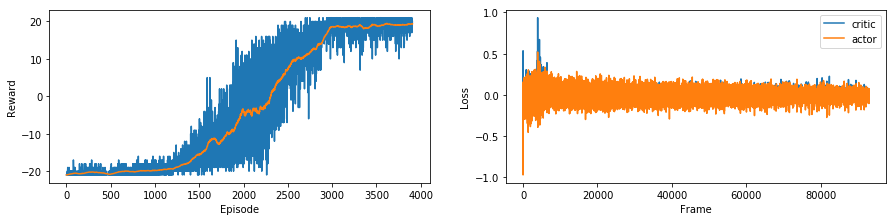

In [11]:
plot_durations(agent)

In [12]:
agent.save("models/pong A2C")